# The 3 E's 

## Using world development indicators to predict PISA scores

Have you ever been curious on how the development indicators of a country may be linked in some way?  What if there were a way to predict the performance of educational scores by looking at the development indicators of a country?  In my project, I will attempt just that.  

To hone in on data that tells a story, I have chose to look at 3 specific indicator groupings, affectionately titled, "The 3 E's".  The 3 E's and some of the indicator codes you will see under each one are as follows:

* Education - Enrollment rates, ratio of teachers to students,vocational versus primary school enrollments
* Economy - Gross domestic productic (GDP), inflation, 
* Employment - Wage & salaried workers, unemployment rates based on different criteria

The 3 E's contain a variety of indicators.  In my project, you will see indicators 

(talk about what is under each indicator like enrollment, vocational versus primary school, employment rates, etc - what makes up the 3 E's)

To do this, I have brought in data from the following sources:
* World Development Indicator Dataset from Kaggle:  https://www.kaggle.com/worldbank/world-development-indicators

The World Development Indicator Dataset includes over a thousand annual indicators for roughly 247 countries.  The dataset has information for 55 years (1960 to 2015).

* PISA data:  https://pisadataexplorer.oecd.org/ide/idepisa/

The PISA data website allows us to select from 100s of countries.  It measures the performance of 15 year old students in the subjects of math, science, and reading.  The data used in my project brings in the PISA scores from the following years:  
* 2000
* 2003
* 2006
* 2009
* 2012
* 2015

What are PISA Scores?

The Programme for International Student Assessment, better known as PISA, is a worldwide study with the intent to evaluate education systems.  The study is done by the Organization for Economic Cooperation and Development (OECD) in member and non-member nations.   

My notebook will guide you through data cleaning, exploration, modeling, and final summary.  Graphs such as correlation heatmaps will show how educational scores and indicator scores relate to each other.  Models will serve as predictors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import random
import re
import textwrap
import warnings
warnings.filterwarnings('ignore')
import csv
import seaborn as sbn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import csv
import seaborn as sbn
%matplotlib inline
from sklearn import linear_model
import math
pd.options.display.float_format = '{:.3f}'.format
from sklearn import preprocessing
sns.set_style('white')
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import statsmodels.api as sm
from sklearn import tree 

In [2]:
Country = pd.read_csv('Country.csv')
CountryNotes = pd.read_csv('CountryNotes.csv')
Indicators = pd.read_csv('Indicators.csv',header = 0,skiprows = range(1,3171013))
Series = pd.read_csv('Series.csv')
SeriesNotes = pd.read_csv('SeriesNotes.csv')
PISA = pd.read_csv('PISA_Combine3.csv')
Region = pd.read_csv('all country.csv')

# Data Cleaning

Let's work on cleaning up our data before we start to model. The 'Indicator' dataset is quite large as it contains indicators for multiple countriest starting in the 1960's. We want to look at the indicators starting in the year 2000 and after. You might have noticed that we added some more code after we imported our csv with the pd.read_csv() funtion. This allows us to keep the column heads (header = 0), and import our 'Indicator' dataset starting at the row dictated by the code. Our imported dataset now starts at the first instance for the year 2000.

In [3]:
Indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,2000,79.537
1,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,2000,65.869
2,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,2000,91.655
3,Arab World,ARB,Access to non-solid fuel (% of population),EG.NSF.ACCS.ZS,2000,81.565
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,2000,78.489


I have imported a variety of datasets. In order to be successful with our modeling, I will need to bring in information from the different datasets and merge them into 1 to work off of.

Let's rename the column name on the 'Region' csv to match the 'Country' csv so that we can use that as the unique indicator to merge our 2 datasets on.

In [4]:
region = Region.rename(columns={'alpha-3': 'CountryCode'})

In [5]:
region.columns

Index(['name', 'alpha-2', 'CountryCode', 'country-code', 'iso_3166-2',
       'region', 'sub-region', 'intermediate-region', 'region-code',
       'sub-region-code', 'intermediate-region-code'],
      dtype='object')

We will first merge the 'Country' csv with the updated 'region' dataframe.  This will allow us to bring in the region and sub-region information.

In [6]:
countrydf = pd.read_csv('Country.csv')
region_update = region

country_region = countrydf.merge(region, on='CountryCode')

Let's merge our new 'country_region' dataframe with the PISA information now.

In [7]:
country_main = country_region
pisadf = pd.read_csv("PISA_Combine3.csv")

combine = country_main.merge(pisadf, on="CountryCode")

As a final merge, we will now combine our updated 'combine' dataframe with the indicator data so that we can work through some models.

In [8]:
indicatordf = pd.read_csv("Indicators.csv")
main = combine.merge(indicatordf, on=['Year','CountryCode'])

In [9]:
main.columns

Index(['CountryCode', 'ShortName', 'TableName', 'LongName', 'Alpha2Code',
       'CurrencyUnit', 'SpecialNotes', 'Region', 'IncomeGroup', 'Wb2Code',
       'NationalAccountsBaseYear', 'NationalAccountsReferenceYear',
       'SnaPriceValuation', 'LendingCategory', 'OtherGroups',
       'SystemOfNationalAccounts', 'AlternativeConversionFactor',
       'PppSurveyYear', 'BalanceOfPaymentsManualInUse',
       'ExternalDebtReportingStatus', 'SystemOfTrade',
       'GovernmentAccountingConcept', 'ImfDataDisseminationStandard',
       'LatestPopulationCensus', 'LatestHouseholdSurvey',
       'SourceOfMostRecentIncomeAndExpenditureData',
       'VitalRegistrationComplete', 'LatestAgriculturalCensus',
       'LatestIndustrialData', 'LatestTradeData', 'LatestWaterWithdrawalData',
       'name', 'alpha-2', 'country-code', 'iso_3166-2', 'region', 'sub-region',
       'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code', 'Year', 'Jurisdiction', 'Average',
      

For project purposes, I will create a copy of my fully merged dataset.  This is being done in the event that I need to refer back to the original version.

In [10]:
project = main.copy()

There are a lot of columns present that we don't need for our analysis.  Let's drop them.

In [11]:
project.drop(["ShortName","LongName","Alpha2Code","Wb2Code","SnaPriceValuation","SpecialNotes","Region","intermediate-region-code","sub-region-code","VitalRegistrationComplete","LatestAgriculturalCensus",
                    "LatestIndustrialData","LatestTradeData","LatestWaterWithdrawalData","SourceOfMostRecentIncomeAndExpenditureData",
                    "LatestHouseholdSurvey","LatestPopulationCensus","ImfDataDisseminationStandard","GovernmentAccountingConcept","intermediate-region",
                    "NationalAccountsBaseYear", "NationalAccountsReferenceYear", "LendingCategory", "OtherGroups", "SystemOfNationalAccounts",
                    "AlternativeConversionFactor", "PppSurveyYear", "BalanceOfPaymentsManualInUse", "ExternalDebtReportingStatus",
                    "region-code", "TableName","alpha-2","iso_3166-2","Jurisdiction" ], axis = 1, inplace = True) 

What do our columns look like now?

In [12]:
project.columns

Index(['CountryCode', 'CurrencyUnit', 'IncomeGroup', 'SystemOfTrade', 'name',
       'country-code', 'region', 'sub-region', 'Year', 'Average',
       'Standard Error', 'Area', 'CountryName', 'IndicatorName',
       'IndicatorCode', 'Value'],
      dtype='object')

In [13]:
project.rename(columns = {'CountryCode':'Country Code Alpha', 'CurrencyUnit':'Currency Unit', 
                          'IncomeGroup':'Income Group', 'SystemofTrade':'System of Trade','name':'Country',
                          'country-code':'Country Code Numeric','region':'Region','sub-region':'Sub Region', 
                          'Average':'PISA Score Average','Standard Error':'PISA Score Standard Error','Area':'Subject',
                          'IndicatorName':'Indicator Name','Indicator Code':'IndicatorCode','Value':'IndicatorCodeValue'}, inplace = True)

In [14]:
project.head(1)

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
0,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2015,nan,nan,Math,Albania,Bank capital to assets ratio (%),FB.BNK.CAPA.ZS,9.700


Let's get an idea of how much of the data is null.  This will allow us to scrub our dataset further.  We can do this a couple of ways.

First Option:  What is the percentage of null for each column in my dataframe?

In [15]:
project.isnull().sum()/len(project)*100

Country Code Alpha           0.000
Currency Unit                0.000
Income Group                 0.000
SystemOfTrade                0.000
Country                      0.000
Country Code Numeric         0.000
Region                       0.000
Sub Region                   0.000
Year                         0.000
PISA Score Average          38.899
PISA Score Standard Error   38.899
Subject                      0.000
CountryName                  0.000
Indicator Name               0.000
IndicatorCode                0.000
IndicatorCodeValue           0.000
dtype: float64

Second option:  What are the counts of the nulls for each column in my dataframe?

In [16]:
project.isnull().sum(axis=0)

Country Code Alpha                0
Currency Unit                     0
Income Group                      0
SystemOfTrade                     0
Country                           0
Country Code Numeric              0
Region                            0
Sub Region                        0
Year                              0
PISA Score Average           297153
PISA Score Standard Error    297153
Subject                           0
CountryName                       0
Indicator Name                    0
IndicatorCode                     0
IndicatorCodeValue                0
dtype: int64

We can see that the columns of 'PISA Score Average' and 'PISA Standard Error' are the only 2 that contain null values.  We are looking at PISA scores for countries for 6 different years.  This is telling us that not all countries have scores for all of the years.  We need to keep this in mind as we work through the data for modeling.

In [17]:
project.Year.unique()

array([2015, 2006, 2003, 2000, 2012, 2009])

In [18]:
project.Subject.unique()

array(['Math', 'Reading', 'Science'], dtype=object)

The data contains multiple indicators that are broken out by country as well as year.  Since we are focusing on the 3 E's, let's create a picklist so that we are able to filter out the codes that we need.

In [19]:
indicators = Indicators['IndicatorName'].unique().tolist()
indicators.sort()

In [20]:
indicators_list = Indicators[['IndicatorName','IndicatorCode']].drop_duplicates().values

In [21]:
indicators_list

array([['Access to electricity (% of population)', 'EG.ELC.ACCS.ZS'],
       ['Access to electricity, rural (% of rural population)',
        'EG.ELC.ACCS.RU.ZS'],
       ['Access to electricity, urban (% of urban population)',
        'EG.ELC.ACCS.UR.ZS'],
       ...,
       ['Fish species, threatened', 'EN.FSH.THRD.NO'],
       ['Mammal species, threatened', 'EN.MAM.THRD.NO'],
       ['Plant species (higher), threatened', 'EN.HPT.THRD.NO']],
      dtype=object)

In [22]:
new_indicators =[]
indicators_code =[]

for ind in indicators_list:
    indicator = ind[0]
    code = ind[1].strip()
    if code not in indicators_code:
        #Delete ,() from indicators and convert all characters to lower case
        modified_indicator = re.sub('[,()]',"",indicator).lower()
        #Replace - with "to"
        modified_indicator = re.sub('-'," to ",modified_indicator).lower()
        new_indicators.append([modified_indicator,code])
        indicators_code.append(code)

In [23]:
Indicators = pd.DataFrame(new_indicators, columns=['IndicatorName','IndicatorCode'])
Indicators = Indicators.drop_duplicates()
print(Indicators.shape)

(1344, 2)


In [24]:
key_word_dict = {}

key_word_dict['Economy'] = ['gdp']
key_word_dict['Education'] = ['literacy','enrolment']
key_word_dict['Employment'] =['employed','employment','umemployed','unemployment']

Using the key word dictionary we created above, let's create a way to see all the different features under a keyword.

In [25]:
def pick_indicator(feature):
   
    indicator_name = []
    
    for indicator_ele in Indicators.values:
        
        if feature not in key_word_dict.keys():
            print("Choose the right feature!")
            break
        
        for word in key_word_dict[feature]:
            
            word_list = indicator_ele[0].split() # it would split from ','
            
            if word in word_list or word+'s' in word_list:
                
                #print(indicator_ele[1])
                
                indicator_name.append(indicator_ele[1])
                
                break
                
    return indicator_name

We now have the ability to use the pick_indicator function in order to see the list of indicators for a chosen group.  Let's set a line of code for each of the 3 E's.

In [26]:
economy = pick_indicator('Economy')

In [27]:
education = pick_indicator('Education')

In [28]:
employment = pick_indicator('Employment')

The 3 dataframes for each PISA subject I want to show have been created.  However, before we go down the path of creating the models, let's do some work to see if our data is highly correlated.  If they are highly correlated, our models will not really show a lot of difference and will be irrelevant.

In [29]:
PISA.groupby(['Jurisdiction','Year','Area']).Average.mean().unstack().corr()

Area,Math,Reading,Science
Area,,,
Math,1.000,0.955,0.977
Reading,0.955,1.000,0.966
Science,0.977,0.966,1.000


The 3 areas are highly correlated with each other.  Since they are all highly correlated with each other, will just focus on 1 subject.  For my supervised learning capstone, I will be focusing on the 3 E's and how they can predict the Math PISA score and performance.

Let' start by creating new data frames that group the applicable indicator codes with the 'E' it is related to.

In [30]:
education_data = project[project.IndicatorCode.isin(education)]
employment_data = project[project.IndicatorCode.isin(employment)]
economy_data = project[project.IndicatorCode.isin(economy)]

In [31]:
economy_list = []

for e in economy_data.IndicatorCode.unique():
    last_val = e.split('.')
    if ('KN' not in last_val)and('CN' not in last_val)and('KD' not in last_val)and('GD' not in last_val)and('ZG' not in last_val)and('RF' not in last_val)and('PPP' not in last_val)and('ZS' not in last_val)and('1524' not in last_val)and('PP' not in last_val)and('NE' not in last_val):
        economy_list.append(e)

In [32]:
education_list = []

for e in education_data.IndicatorCode.unique():
    last_val = e.split('.')
    if ('FE' not in last_val)and('MA' not in last_val)and('GC' not in last_val)and('ENRR' not in last_val)and('1524' not in last_val)and('FM' not in last_val)and('NE' not in last_val):
        economy_list.append(e)

In [33]:
employment_list = []

for e in employment_data.IndicatorCode.unique():
    last_val = e.split('.')
    if ('FE' not in last_val)and('MA' not in last_val)and('0714' not in last_val)and('1524' not in last_val)and('adq_pop_tot' not in last_val)and('NE' not in last_val):
        economy_list.append(e)

In [34]:
#grouped_multiple = education_data.groupby(['Indicator Name', 'IndicatorCode']).agg({'IndicatorCodeValue': ['mean']})
#grouped_multiple

In [35]:
education_data.head(2)

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
430,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in primary education, both sexes (nu...",SE.PRM.ENRL,222402.000
431,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,408980.000


We have our new data frames that only contain indicator codes for our 3 'E's.  For our models, we want to look at how the 3 E's can help us predict the PISA scores for Math.  We wil need to combine the 3 dataframes we just created for each of our E's.

In [36]:
e_model = pd.concat([education_data, employment_data, economy_data])
e_model.tail()

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
763769,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Price level ratio of PPP conversion factor (GD...,PA.NUS.PPPC.RF,0.351
763827,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,"Services, etc., value added (% of GDP)",NV.SRV.TETC.ZS,41.704
763872,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Total natural resources rents (% of GDP),NY.GDP.TOTL.RT.ZS,12.412
763878,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Trade (% of GDP),NE.TRD.GNFS.ZS,156.554
763879,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Trade in services (% of GDP),BG.GSR.NFSV.GD.ZS,14.196


In [37]:
e_model.shape

(150120, 16)

In [38]:
e_model.dtypes

Country Code Alpha            object
Currency Unit                 object
Income Group                  object
SystemOfTrade                 object
Country                       object
Country Code Numeric           int64
Region                        object
Sub Region                    object
Year                           int64
PISA Score Average           float64
PISA Score Standard Error    float64
Subject                       object
CountryName                   object
Indicator Name                object
IndicatorCode                 object
IndicatorCodeValue           float64
dtype: object

In [39]:
rf_education = e_model[['Country','Region','Sub Region','Year','IndicatorCodeValue','IndicatorCode','PISA Score Average']].dropna()
#rf_education

The big thing we can see is that there are a lot of Indicator Codes.  We also have a lot of Indicator Codes that are the same, but are based on Male, Female, or Total.  That is going to cause a lot of correlation in itself. When I created our original 3 lists, I tried to remove any Indicator Codes that are only broken out by Male or Female.  The same can be said about some other indicator codes that seem to be correlated ot each other.

In [40]:
rf_education.head()

,Country,Region,Sub Region,Year,IndicatorCodeValue,IndicatorCode,PISA Score Average
6852,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.TENR,349.000
6853,Albania,Europe,Southern Europe,2000,92.815,SE.PRM.TENR.FE,349.000
6854,Albania,Europe,Southern Europe,2000,94.351,SE.PRM.TENR.MA,349.000
7022,Albania,Europe,Southern Europe,2000,283249.000,SE.PRM.ENRL,349.000
7023,Albania,Europe,Southern Europe,2000,365664.000,SE.SEC.ENRL,349.000


In [41]:
main_ind = employment_list
main_ind.extend(education_list)
main_ind.extend(economy_list)
main_ind[0:5]

['NY.GDP.MKTP.CD',
 'NY.GDP.PCAP.CD',
 'SE.PRM.ENRL',
 'SE.SEC.ENRL',
 'SE.SEC.ENRL.VO']

In [42]:
rf_education_clean = rf_education[rf_education.IndicatorCode.isin(main_ind)]
rf_education_clean.head(5)

,Country,Region,Sub Region,Year,IndicatorCodeValue,IndicatorCode,PISA Score Average
6852,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.TENR,349.000
7022,Albania,Europe,Southern Europe,2000,283249.000,SE.PRM.ENRL,349.000
7023,Albania,Europe,Southern Europe,2000,365664.000,SE.SEC.ENRL,349.000
7025,Albania,Europe,Southern Europe,2000,14501.000,SE.SEC.ENRL.VO,349.000
7368,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.NENR,349.000


In [43]:
len(main_ind)

28

We have indicator codes that don't really mean a lot to someone who isn't used to the data.  Let's fix that by renaming our indicator codes to something that makes more sense.

In [44]:
rf_education_clean['IndicatorCode'].replace({'NY.GDP.MKTP.CD':'GDP at market prices',
'NY.GDP.PCAP.CD':'GDP per capita',
'SE.ADT.LITR.ZS':'Adult literacy rate',
'SE.PRM.ENRL':'Primary education enrollment',
'SE.PRM.NENR':'Net enrollment rate',
'SE.PRM.PRIV.ZS':'Primary education in private institutions enrollment',
'SE.PRM.TENR':'Adjusted primary education net enrollment rate',
'SE.SEC.ENRL':'Secondary education enrollment',
'SE.SEC.ENRL.VO':'Secondary vocational enrollment',
'SE.SEC.NENR':'Secondary education net enrollment',
'SE.SEC.PRIV.ZS':'Secondary education in private institutions enrollment',
'SL.AGR.EMPL.ZS':'Agriculture employment',
'SL.EMP.MPYR.ZS':'Total employers',
'SL.EMP.SELF.ZS':'Self-employed',
'SL.EMP.TOTL.SP.ZS':'Employment to population',
'SL.EMP.VULN.ZS':'Vulnerable employment total',
'SL.EMP.WORK.ZS':'Wage and salaried workers',
'SL.FAM.WORK.ZS':'Contributing family workers',
'SL.GDP.PCAP.EM.KD':'GDP per person employed',
'SL.IND.EMPL.ZS':'Employment in industry',
'SL.SRV.EMPL.ZS':'Employment in services',
'SL.TLF.PART.ZS':'Part-time employment',
'SL.UEM.LTRM.ZS':'Long-term employment',
'SL.UEM.NEET.ZS':'Youth not in education, employment or training',
'SL.UEM.PRIM.ZS':'Unemployment with primary education',
'SL.UEM.SECO.ZS':'Unemployment with secondary education',
'SL.UEM.TERT.ZS':'Unemployment with tertiary education',
'SL.UEM.TOTL.ZS':'Total Unemployment'},inplace = True)

In [45]:
main_pivot = pd.pivot_table(data = rf_education_clean, index=['Country','Year'], columns='IndicatorCode', values='IndicatorCodeValue', aggfunc=np.mean)
main_pivot.fillna(main_pivot.mean(),inplace = True)
main_pivot

IndicatorCode                                            Adjusted primary education net enrollment rate  \
Country                                            Year                                                   
Albania                                            2000                                          93.602   
                                                   2009                                          97.857   
                                                   2012                                          97.857   
Australia                                          2000                                          94.153   
                                                   2003                                          94.418   
                                                   2006                                          94.774   
                                                   2009                                          96.616   
                                                   2012                                          96.927   
Austria                                            2000                                          97.857   
                                                   2003                                          97.857   
                                                   2006                                          97.857   
                                                   2009                                          97.857   
                                                   2012                                          97.857   
Belgium                                            2000                                          99.191   
                                                   2003                                          98.352   
                                                   2006                                          97.247   
                                                   2009                                          99.052   
                                                   2012                                          98.969   
Brazil                                             2000                                          97.857   
                                                   2003                                          97.857   
                                                   2006                                          97.857   
                                                   2009                                          97.857   
                                                   2012                                          97.857   
Bulgaria                                           2000                                          97.904   
                                                   2006                                          92.312   
                                                   2009                                          99.084   
                                                   2012                                          96.410   
Canada                                             2000                                          99.923   
                                                   2003                                          97.857   
                                                   2006                                          97.857   
...                                                                                                 ...   
Thailand                                           2000                                          97.857   
                                                   2003                                          97.857   
                                                   2006                                          93.861   
                                                   2009                                          95.610   
                                         

We have created a pivot table to see the correlation of PISA scores against the World Development Indicators for the Math subject.  Before we proceed with modeling, let's see if we will have highly correlated data.  If we have highly correlated data, this will lead to overfitting - which will render our model useless.

We went ahead and accounted for this by taking out indicator codes from the 3 E lists that would be highly correlated.  By doing this, we also decreased the number of features to make the model more meaningful.

In [46]:
e_model.columns

Index(['Country Code Alpha', 'Currency Unit', 'Income Group', 'SystemOfTrade',
       'Country', 'Country Code Numeric', 'Region', 'Sub Region', 'Year',
       'PISA Score Average', 'PISA Score Standard Error', 'Subject',
       'CountryName', 'Indicator Name', 'IndicatorCode', 'IndicatorCodeValue'],
      dtype='object')

Text(0.5, 1.05, 'Correlation of PISA and Indicators for Math')

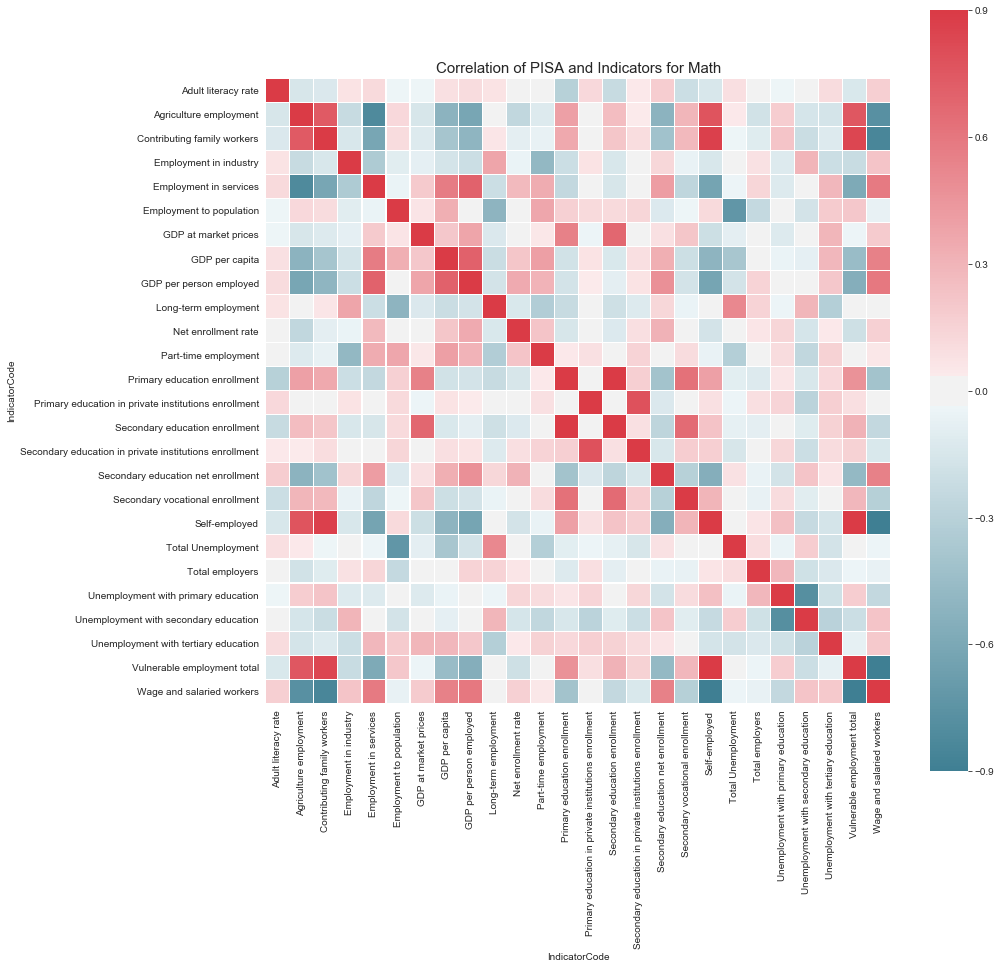

In [47]:
corr = main_pivot.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=False, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white',center = 0,vmin = -.9, vmax = .9)
plt.title('Correlation of PISA and Indicators for Math', y=1.05, size=15)

Text(0.5, 1.05, 'Correlation of PISA and Indicators for Math')

<Figure size 1008x1008 with 0 Axes>

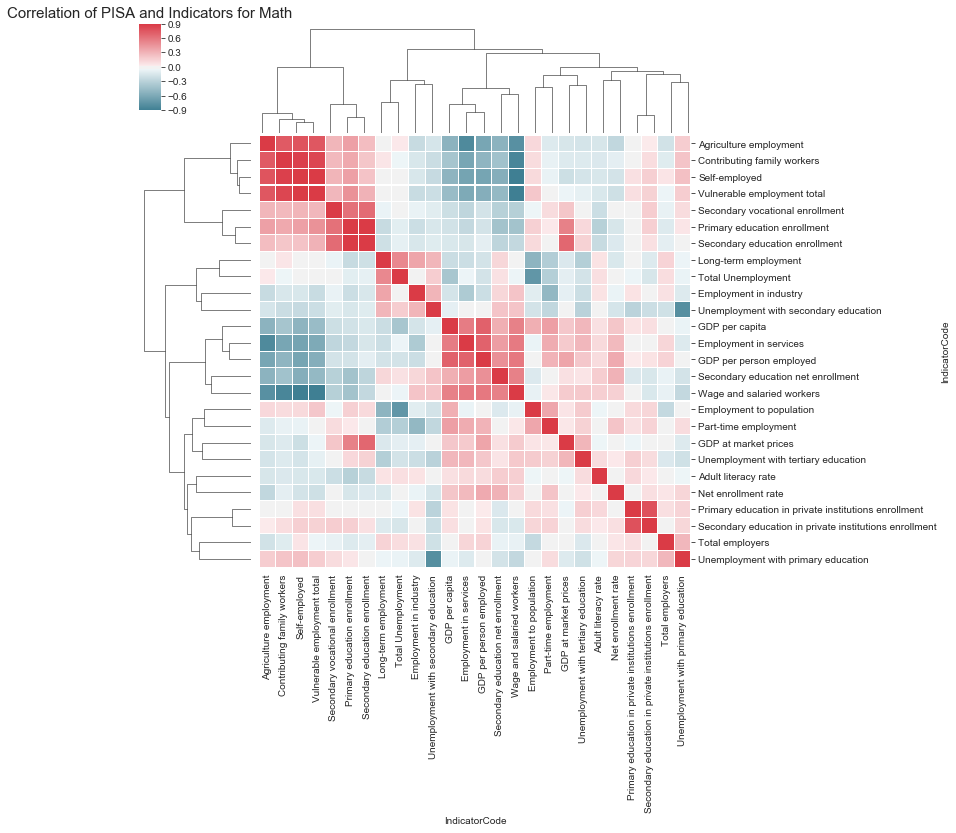

In [48]:
corr = main_pivot.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.clustermap(corr, cbar = True,  square = True, annot=False, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white',center = 0,vmin = -.9, vmax = .9)
plt.title('Correlation of PISA and Indicators for Math', y=1.05, size=15)

In [49]:
#corr.iloc[0:33,0:33]
corr

IndicatorCode,Adult literacy rate,Agriculture employment,Contributing family workers,Employment in industry,Employment in services,Employment to population,GDP at market prices,GDP per capita,GDP per person employed,Long-term employment,...,Secondary education net enrollment,Secondary vocational enrollment,Self-employed,Total Unemployment,Total employers,Unemployment with primary education,Unemployment with secondary education,Unemployment with tertiary education,Vulnerable employment total,Wage and salaried workers
IndicatorCode,,,,,,,,,,,,,,,,,,,,,
Adult literacy rate,1.000,-0.154,-0.130,0.074,0.114,-0.038,-0.040,0.088,0.110,0.074,...,0.179,-0.204,-0.143,0.094,0.009,-0.038,0.035,0.108,-0.136,0.172
Agriculture employment,-0.154,1.000,0.741,-0.229,-0.819,0.121,-0.154,-0.519,-0.618,-0.011,...,-0.514,0.290,0.769,0.044,-0.179,0.178,-0.161,-0.162,0.756,-0.768
Contributing family workers,-0.130,0.741,1.000,-0.143,-0.614,0.107,-0.113,-0.392,-0.500,0.063,...,-0.410,0.275,0.866,-0.040,-0.106,0.219,-0.213,-0.117,0.840,-0.849
Employment in industry,0.074,-0.229,-0.143,1.000,-0.350,-0.105,-0.081,-0.165,-0.211,0.379,...,0.133,-0.058,-0.146,0.025,0.083,-0.113,0.299,-0.207,-0.218,0.220
Employment in services,0.114,-0.819,-0.614,-0.350,1.000,-0.055,0.197,0.574,0.700,-0.210,...,0.411,-0.261,-0.633,-0.048,0.134,-0.119,-0.018,0.287,-0.584,0.588
Employment to population,-0.038,0.121,0.107,-0.105,-0.055,1.000,0.063,0.325,-0.003,-0.508,...,-0.120,-0.039,0.118,-0.726,-0.243,0.004,-0.174,0.189,0.210,-0.064
GDP at market prices,-0.040,-0.154,-0.113,-0.081,0.197,0.063,1.000,0.206,0.374,-0.128,...,0.091,0.213,-0.197,-0.088,0.026,-0.117,0.023,0.289,-0.044,0.185
GDP per capita,0.088,-0.519,-0.392,-0.165,0.574,0.325,0.206,1.000,0.710,-0.217,...,0.327,-0.201,-0.512,-0.386,0.017,-0.054,-0.078,0.284,-0.450,0.548
GDP per person employed,0.110,-0.618,-0.500,-0.211,0.700,-0.003,0.374,0.710,1.000,-0.171,...,0.474,-0.170,-0.625,-0.176,0.148,-0.027,-0.033,0.206,-0.555,0.597


In [50]:
pisa_math = pd.pivot_table(data = rf_education_clean, index=['Country','Year'],values='PISA Score Average', fill_value = 0,aggfunc=np.mean)
pisa_math

PISA Score Average
Country                                            Year                    
Albania                                            2000             349.000
                                                   2009             384.333
                                                   2012             395.000
Australia                                          2000             528.000
                                                   2003             524.500
                                                   2006             520.000
                                                   2009             518.667
                                                   2012             512.333
Austria                                            2000             492.000
                                                   2003             498.500
                                                   2006             502.000
                                                   2009             486.667
                                                   2012             500.667
Belgium                                            2000             507.000
                                                   2003             518.000
                                                   2006             510.333
                                                   2009             509.333
                                                   2012             509.667
Brazil                                             2000             396.000
                                                   2003             379.500
                                                   2006             384.333
                                                   2009             401.000
                                                   2012             399.333
Bulgaria                                           2000             430.000
                                                   2006             416.333
                                                   2009             432.000
                                                   2012             440.333
Canada                                             2000             534.000
                                                   2003             530.000
                                                   2006             529.333
...                                                                     ...
Thailand                                           2000             431.000
                                                   2003             418.500
                                                   2006             418.333
                                                   2009             421.667
                                                   2012             437.333
Trinidad and Tobago                                2009             413.333
Tunisia                                            2003             367.000
                                                   2006             377.000
                                                   2009             392.000
                                                   2012             396.667
Turkey                                             2003             432.000
                                                   2006             431.667
                                                   2009             454.333
                                                   2012             462.000
United Arab Emirates                               2012             441.333
United Kingdom of Great Britain and Northern Ir... 2000             523.000
                                                   2003             507.500
                                                   2006             501.667
                                                   2009             500.000
                                                   2012             502.333
United States of America     

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

df1 = rf_education_clean
y = pisa_math
X = main_pivot
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

radm = RandomForestRegressor()
radm.fit(Xtrain, ytrain)

reg = radm
indices = np.argsort(radm.feature_importances_)[::-1]

print('Feature ranking:')

for f in range(len(indices)):
    print('%d. feature %d %s (%f)' % (f+1 , 
                                      indices[f], 
                                      X.columns[indices[f]], 
                                      radm.feature_importances_[indices[f]]))

Feature ranking:
1. feature 8 GDP per capita (0.424851)
2. feature 9 GDP per person employed (0.168234)
3. feature 12 Part-time employment (0.064929)
4. feature 19 Self-employed (0.060121)
5. feature 6 Employment to population (0.048484)
6. feature 23 Unemployment with secondary education (0.046948)
7. feature 25 Vulnerable employment total (0.026052)
8. feature 5 Employment in services (0.025026)
9. feature 14 Primary education in private institutions enrollment (0.017861)
10. feature 24 Unemployment with tertiary education (0.015804)
11. feature 4 Employment in industry (0.015754)
12. feature 11 Net enrollment rate (0.011055)
13. feature 21 Total employers (0.009703)
14. feature 20 Total Unemployment (0.009398)
15. feature 16 Secondary education in private institutions enrollment (0.008732)
16. feature 10 Long-term employment (0.007527)
17. feature 18 Secondary vocational enrollment (0.005704)
18. feature 22 Unemployment with primary education (0.004629)
19. feature 3 Contributing fa

In [52]:
radm.score(Xtrain,ytrain)

0.9575154360666369

In [53]:
radm.score(Xtest,ytest)

0.6879788053253675

In [54]:
#import PCA and the components
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

In [55]:
x_scale=StandardScaler().fit_transform(X)

pca = PCA(n_components=10)
update_x = pca.fit_transform(x_scale)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.25838919 0.13823874 0.09377296 0.07704103 0.06560232 0.05006152
 0.04654954 0.03722761 0.03466778 0.03100037]
[40.88106234 29.90197629 24.62769783 22.3226646  20.59892679 17.99438537
 17.35172767 15.51735162 14.97435119 14.16016856]


In [56]:
pca.explained_variance_ratio_.sum()

0.8325510531300707

In [57]:
cross_val_score(radm, update_x, y, cv=5)

array([ 0.58880992,  0.37537276, -0.31280166, -0.09877497, -0.20192862])

In [58]:
cross_val_score(radm, X, y, cv=5)

array([0.70838949, 0.69056986, 0.30897504, 0.3206959 , 0.25941069])

The cross validation score does not look the best.  It's a little all over the place.  How can we get this looking a little better?  How about we experiement by taking out some other features.  What would our random forest and PCA look like after we do som feature selection?


In [59]:
len(X.columns)

28

In [60]:
X.columns[:28]

Index(['Adjusted primary education net enrollment rate', 'Adult literacy rate',
       'Agriculture employment', 'Contributing family workers',
       'Employment in industry', 'Employment in services',
       'Employment to population', 'GDP at market prices', 'GDP per capita',
       'GDP per person employed', 'Long-term employment',
       'Net enrollment rate', 'Part-time employment',
       'Primary education enrollment',
       'Primary education in private institutions enrollment',
       'Secondary education enrollment',
       'Secondary education in private institutions enrollment',
       'Secondary education net enrollment', 'Secondary vocational enrollment',
       'Self-employed', 'Total Unemployment', 'Total employers',
       'Unemployment with primary education',
       'Unemployment with secondary education',
       'Unemployment with tertiary education', 'Vulnerable employment total',
       'Wage and salaried workers',
       'Youth not in education, employment or t

What happens when we take out the features that are a little more specialized and stuck with features that are a little more encompassing?

In [61]:
#columns = ['Adjusted primary education net enrollment rate',
       #'Contributing family workers','Agriculture employment',
       #'Employment to population',
       #'Secondary education net enrollment', 'Secondary vocational enrollment',
       #'Total Unemployment', 'Total employers',
       #'Unemployment with tertiary education', 'Vulnerable employment total',
       #'Youth not in education, employment or training','Self-employed']

#X_trim = X.drop(columns=columns)

# Rerun model with reduced data set
#cross_val_score(radm, X_trim, y, cv=5)

### Linear Regression

In [62]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#training
mlregr=linear_model.LinearRegression()
mlregr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
mlregr.coef_

array([[ 7.77315849e-01,  6.00636759e-01, -1.72465372e+00,
         1.33701054e+00, -7.39316144e-01, -1.96615399e+00,
         1.56824314e+00, -1.86417548e-12, -2.17554843e-04,
         2.25105646e-03,  6.06551273e-02, -1.00278242e-01,
        -6.16406377e-01,  5.47871889e-07, -1.06217900e+00,
        -2.24577548e-06,  7.01098052e-01,  8.77175165e-01,
         1.27150906e-05, -6.22430418e+00, -2.40415139e-01,
         3.04108554e+00, -6.22438900e-03,  2.68565567e-01,
        -9.29953022e-02,  3.63143289e-01, -4.53825349e+00,
         3.01050209e-01]])

In [64]:
mlregr.score(Xtest,ytest) 

0.6506166700292718

Compare my linear regression to Partial least squares regression.

PLSR is iterative. It first tries to find the vector within the 𝑛-dimensional space of 𝑋 with the highest covariance with 𝑦. Then it looks for a second vector, perpendicular to the first, that explains the highest covariance with 𝑦 that remains after accounting for the first vector. This continues for as many components as we permit, up to 

R-squared regression: 0.7517106349145272
R-squared PLSR: 0.6593524595031468


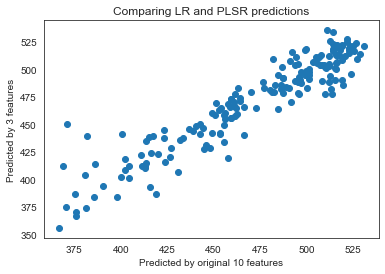

In [65]:
from sklearn.cross_decomposition import PLSRegression
# Save predicted values.
Y_pred = mlregr.predict(Xtrain)
print('R-squared regression:', mlregr.score(Xtrain, ytrain))

# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls1.fit(Xtrain, ytrain)

# Save predicted values.
Y_PLS_pred = pls1.predict(Xtrain)
print('R-squared PLSR:', pls1.score(Xtrain, ytrain))

# Compare the predictions of the two models
plt.scatter(Y_pred,Y_PLS_pred) 
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 3 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

R-squared regression: 0.6506166700292718
R-squared PLSR: 0.7618906533583376


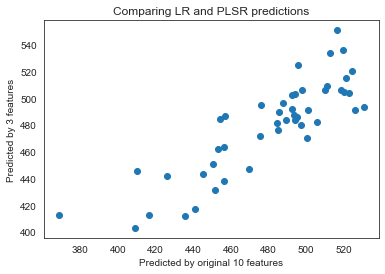

In [66]:
from sklearn.cross_decomposition import PLSRegression
# Save predicted values.
Y_pred = mlregr.predict(Xtest)
print('R-squared regression:', mlregr.score(Xtest, ytest))

# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls1.fit(Xtest, ytest)

# Save predicted values.
Y_PLS_pred = pls1.predict(Xtest)
print('R-squared PLSR:', pls1.score(Xtest, ytest))

# Compare the predictions of the two models
plt.scatter(Y_pred,Y_PLS_pred) 
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 3 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

Looking at the Linear Regression, the accuracy might not be the best; however, this model shows that the data is not suffering from overfitting.  In looking at the scatter plots for the training and test data, there is definitely a trend that is being reflected.

In [67]:
Xtrain.shape

(184, 28)

In [68]:
mlregr=linear_model.LinearRegression()
mlregr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Lasso Regression

In [69]:
lass = linear_model.Lasso(alpha=.35)#lasso regression loop to show alpha differences in notebook
#can pick the very best alpha to get the best score - can create a loop around the alpha to do (alpha = 1, alpha = .05)
lassfit = lass.fit(Xtrain, ytrain)

print('\n Percentage accuracy training set')
print(lass.score(Xtrain, ytrain))

print('\n Percentage accuracy testing set')
print(lass.score(Xtest, ytest))

origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)


 Percentage accuracy training set
0.7511811679349916

 Percentage accuracy testing set
0.6498161266165647

Parameter estimates for the model with few features:
[ 5.17402946e-01  1.93072987e-01 -1.22096737e+00  1.17462340e+00
 -2.61274443e-01 -1.46224362e+00  1.49518964e+00 -1.76621677e-12
 -2.29832469e-04  2.29496801e-03  6.19681928e-02 -0.00000000e+00
 -5.42671201e-01  4.63662743e-07 -1.04901353e+00 -2.19781065e-06
  6.64177606e-01  8.64093085e-01  1.29151461e-05 -5.75508473e+00
 -2.21770002e-01  2.55907969e+00  2.72195904e-02  2.93591005e-01
 -8.75934371e-02  3.11002047e-01 -4.20669669e+00  2.11864476e-01
  7.11830658e+02]


The R2 for both the training and testing set look pretty close.  We have been able to narrow down the features which has eliminated most of the overfitting.  The numbers make more sense now.

Lasso Regression is extremely useful when dealing with many predictors.  My data set for the world development indicators had hundreds of lines that could result in messy models.  Lasso is helpful in creating an overfitting protection through shrinkage and also create sparsity through feature selection.

### Ridge Regression
#### Use Ridge Regression and Lasso Regression - instead of the Ridge Logistic Regression.  Ridge and Lasso regression will select features.

In [70]:
ytest.values.flatten()

array([501.66666667, 402.33333333, 520.66666667, 493.5       ,
       465.66666667, 499.        , 396.        , 421.66666667,
       489.66666667, 501.        , 479.        , 496.        ,
       509.        , 441.33333333, 500.        , 523.        ,
       486.66666667, 482.        , 408.66666667, 515.33333333,
       502.        , 472.        , 498.        , 526.66666667,
       541.66666667, 458.66666667, 518.66666667, 412.        ,
       474.        , 486.66666667, 414.        , 497.        ,
       486.        , 474.        , 540.33333333, 413.33333333,
       497.5       , 485.        , 490.33333333, 516.        ,
       468.33333333, 498.5       , 382.66666667, 542.66666667,
       476.33333333, 488.        , 440.33333333])

In [71]:
ridge = linear_model.Ridge()
fit = ridge.fit(Xtrain, ytrain)

print('Coefficients')
print(pd.DataFrame(fit.coef_, columns=Xtest.columns))
print('\nIntercept:{}'.format(fit.intercept_))
    
print('\n Percentage accuracy training set')
print(ridge.score(Xtrain, ytrain))

print('\n Percentage accuracy testing set')
print(ridge.score(Xtest, ytest))

pred_y_sklearn = ridge.predict(Xtest)
print('\n Indicator Code and PISA Scores')
print(pd.crosstab(pred_y_sklearn.flatten(), ytest.values.flatten()))

Coefficients
IndicatorCode  Adjusted primary education net enrollment rate  \
0                                                       0.773   

IndicatorCode  Adult literacy rate  Agriculture employment  \
0                            0.593                  -1.714   

IndicatorCode  Contributing family workers  Employment in industry  \
0                                    1.328                  -0.733   

IndicatorCode  Employment in services  Employment to population  \
0                              -1.954                     1.565   

IndicatorCode  GDP at market prices  GDP per capita  GDP per person employed  \
0                            -0.000          -0.000                    0.002   

IndicatorCode  ...  Secondary vocational enrollment  Self-employed  \
0              ...                            0.000         -6.190   

IndicatorCode  Total Unemployment  Total employers  \
0                          -0.244            3.017   

IndicatorCode  Unemployment with primary edu

The Ridge Regression model is pretty interesting in the read out it is providing us.  By looking at the coefficients, we see some detailed insights.  For example, the higher the total employers, the higher the PISA score (4.731).  However, the higher the Agriculture employment, the lower the PISA (-1.733).  Similar to the Lasso Regression, the percentage accuracy between the training and testing set is close which is indicative of the decrease of overfitting.

Just for fun, let's see if lasso and ridge yield the same r^2 results.  

Lasso Regression

In [72]:
alphas = []
r_sq = []
for a in np.linspace(0.01, 0.99, 50):
    lassBig = linear_model.Lasso(alpha = a)
    lassBig.fit(Xtrain, ytrain)
    alphas.append(a)
    r_sq.append(lassBig.score(Xtest, ytest))

Ridge Regression

In [73]:
alphas2 = []
r_sq2 = []
for a in np.linspace(0.01, 0.99, 50):
    ridgeBig = linear_model.Ridge(alpha = a, fit_intercept=False)
    ridgeBig.fit(Xtrain, ytrain)
    alphas2.append(a)
    r_sq2.append(ridgeBig.score(Xtest, ytest))

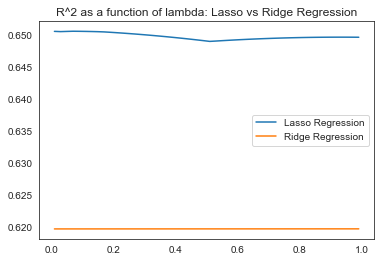

In [74]:
plt.plot(alphas, r_sq, label = 'Lasso Regression')
plt.plot(alphas2, r_sq2, label = 'Ridge Regression')
plt.title('R^2 as a function of lambda: Lasso vs Ridge Regression')
plt.legend()
plt.show()

The answer is No.  Lasso and ridge do not yield the same r^2 results.  If alphas = 0, then it is Ridge.  For Lasso, alphas can vary from 0 to infinity.

## Gradient Boost

In [79]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(Xtest, ytest)

predict_train = radm.predict(Xtrain)
predict_test = radm.predict(Xtest)

# Accuracy tables.
table_train = pd.crosstab(ytrain, predict_train, margins=True)
table_test = pd.crosstab(ytest, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

ValueError: Loss 'deviance' not supported. 

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### K Nearest Neighbors (KNN)

In [80]:
from sklearn import neighbors

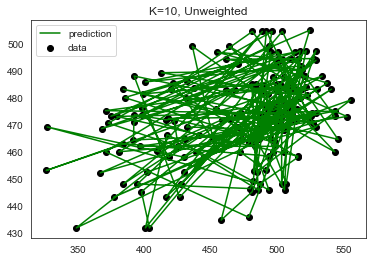

In [81]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(Xtrain, ytrain)

# Trailing underscores are a common convention for a prediction.
y_train_ = knn.predict(Xtrain)

plt.scatter(ytrain, y_train_, c='k', label='data')
plt.plot(ytrain, y_train_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

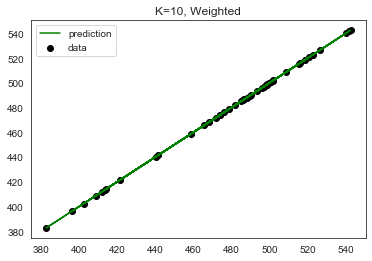

In [82]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(Xtest, ytest)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

y_test_ = knn_w.predict(Xtest)

plt.scatter(ytest, y_test_, c='k', label='data')
plt.plot(ytest, y_test_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

In [83]:
score = cross_val_score(knn, Xtest, ytest, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, Xtest, ytest, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.06 (+/- 0.33)
Weighted Accuracy: -0.14 (+/- 0.46)
